In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
from sklearn.metrics import confusion_matrix,accuracy_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, auc
from tensorflow import keras
import matplotlib.pyplot as plt
import shap
import os
import json
import re
import numpy as np
from pathlib import Path
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
gi_training = pd.read_parquet('../data/processed/gi_binary_training.parquet')
X = gi_training.drop(columns=['sample','disease_present'])
y = gi_training['disease_present']
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, stratify = y)

## XGBoost

In [5]:
# make search space for bayes tuning
search_spaces = {
    "max_depth": Integer(3, 8),              
    "learning_rate": Real(1e-3, 0.3, prior="log-uniform"), 
    "subsample": Real(0.5, 1.0),                
    "colsample_bytree": Real(0.5, 1.0),         
    "reg_lambda": Real(1e-3, 10.0, prior="log-uniform"),    
    "reg_alpha": Real(1e-3, 10.0, prior="log-uniform"),   
}

# create model 
bst = xgb.XGBClassifier(
    n_estimators=400, 
    max_depth=5, 
    learning_rate=0.08, 
    objective='binary:logistic',
    eval_metric = 'auc',
    tree_method = 'hist',
    )


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

opt = BayesSearchCV(
    estimator=bst,             
    search_spaces=search_spaces, 
    n_iter=10,                  
    scoring="roc_auc",          
    cv=cv,                     
    n_jobs=-1,                  
    verbose=1,                  
    random_state=42             
)

# fit model
opt.fit(X_train, y_train)

print(opt.best_params_)
print(opt.best_score_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
OrderedDict([('colsample_bytree', 0.705051979426657), ('learning_rate', 0.06348409107711134), ('max_depth', 8), ('reg_alpha', 0.018331515651137147), ('reg_lambda', 0.47928274405969296), ('subsample', 0.7070593162427692)])
0.8444589252106208


In [6]:
#save params
dump_path = '../params/best_params_binary_gi_xgboost.json'
file_mode = 'x' if not Path(dump_path).exists() else 'w'
with open(dump_path, file_mode) as f:
    json.dump(opt.best_params_, f)

#save model
best_model = opt.best_estimator_
best_model.save_model('../saved_models/binary_gi_xgboost_model.json')


### confusion matrix

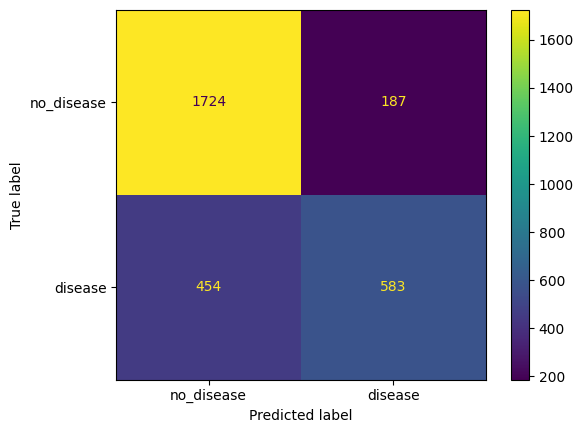

In [4]:
best_model = xgb.XGBClassifier()
best_model.load_model('../saved_models/binary_gi_xgboost_model.json')
preds = best_model.predict(X_test)
cm = confusion_matrix(y_test,preds)
cm_disp = ConfusionMatrixDisplay(cm,display_labels=['no_disease','disease'])
cm_disp.plot()
plt.show()

### shap

/opt/anaconda3/envs/ml/lib/python3.9/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


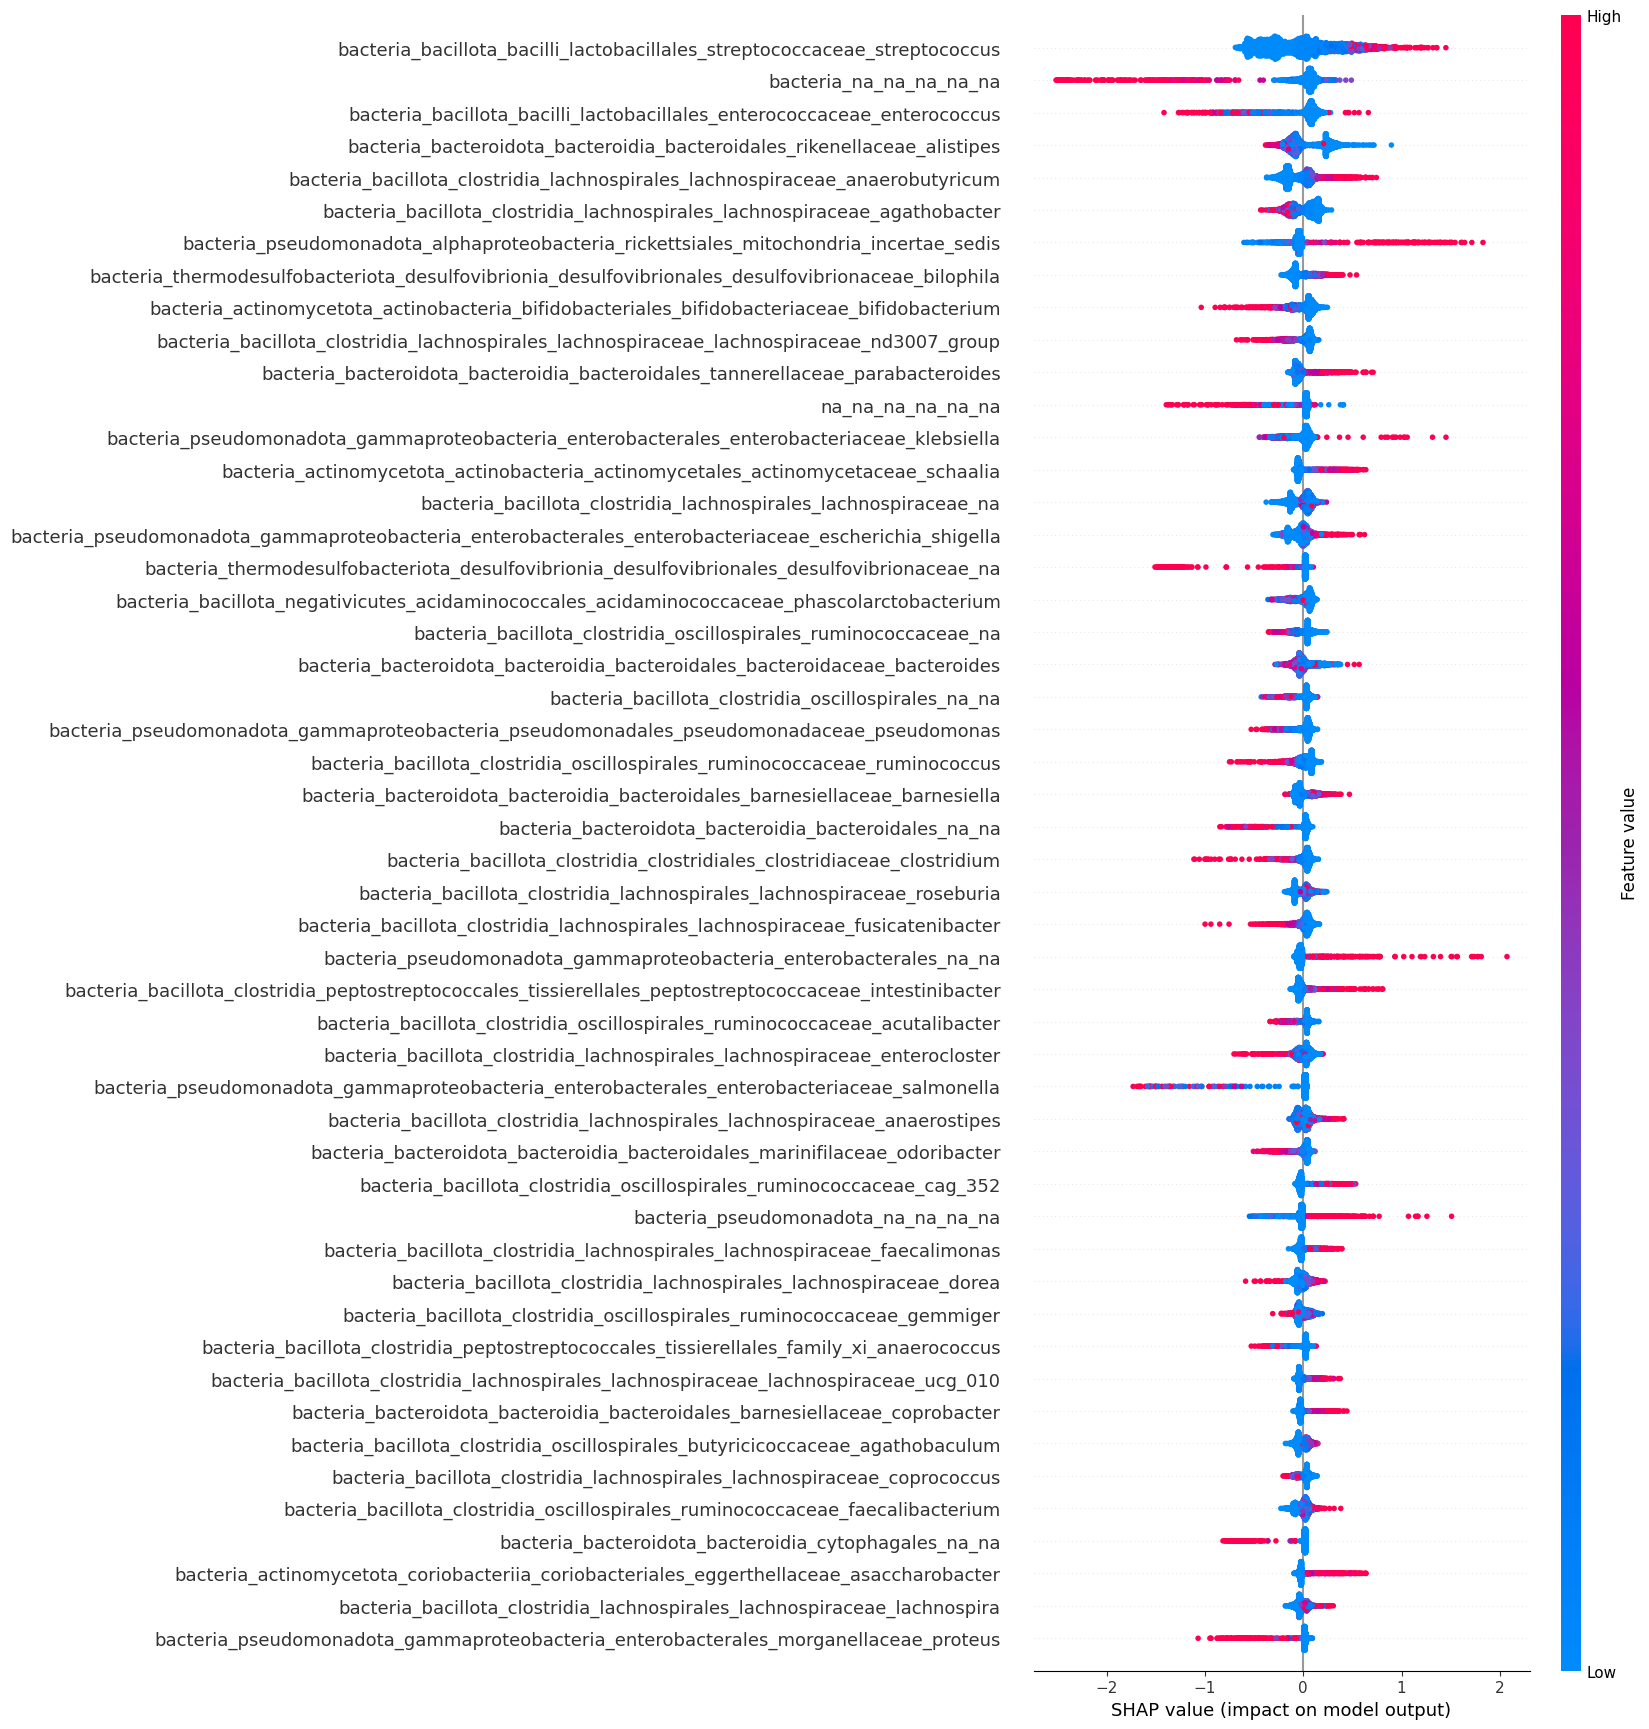

In [8]:
# compute SHAP values


shortened_names = [' '.join(taxon.split('_')[-2:]) for taxon in X_test.columns]

explainer = shap.Explainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values,X_test, max_display=50, feature_names=None)

### roc auc

ROC AUC: 0.8639072274559256


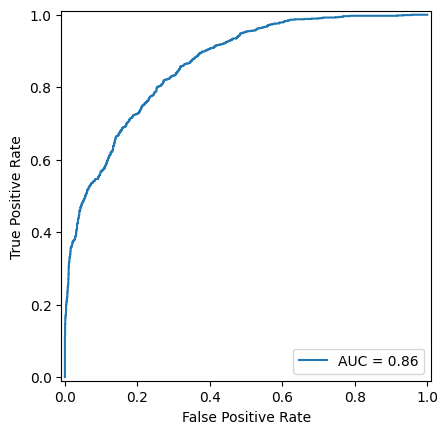

In [6]:
y_probs = best_model.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test,y_probs)
print('ROC AUC:',roc_auc)
fpr, tpr, thresholds = roc_curve(y_test,y_probs)

roc_disp = RocCurveDisplay(fpr = fpr,tpr = tpr,roc_auc=roc_auc)
roc_disp.plot()

## logistic regression

0.7398177429862236


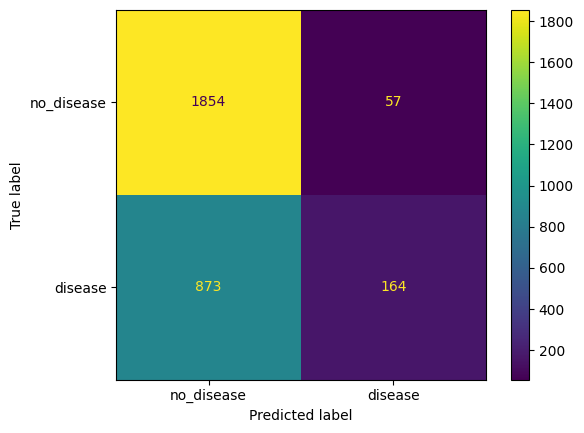

In [18]:
logist = LogisticRegression(penalty='l2')
logist.fit(X_train,y_train)
preds = logist.predict(X_test)
logist_roc_auc = roc_auc_score(y_test,logist.predict_proba(X_test)[:,1])
print(logist_roc_auc)
logist_cm = confusion_matrix(y_test,preds)
logist_cm_disp = ConfusionMatrixDisplay(logist_cm,display_labels=['no_disease','disease'])
logist_cm_disp.plot()
plt.show()

## neural net (sucks)

In [73]:
model = keras.Sequential([
    keras.layers.Input((X_train.shape[1],)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.001))

history = model.fit(X_train,y_train,epochs = 60, batch_size=1028,validation_split=0.1, verbose = 1)

Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5566 - loss: 0.6850 - val_accuracy: 0.6316 - val_loss: 0.6620
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6525 - loss: 0.6502 - val_accuracy: 0.6316 - val_loss: 0.6489
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6505 - loss: 0.6364 - val_accuracy: 0.6316 - val_loss: 0.6430
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6554 - loss: 0.6247 - val_accuracy: 0.6441 - val_loss: 0.6286
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6709 - loss: 0.6125 - val_accuracy: 0.6576 - val_loss: 0.6134
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6784 - loss: 0.5984 - val_accuracy: 0.6644 - val_loss: 0.5961
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6800 - loss: 0.5865 - val_accuracy: 0.6847 - val_loss: 0.5779
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6939 - loss: 0.5708 - val_accuracy: 0.6994 - val_loss: 0.5626


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.7679601474890082


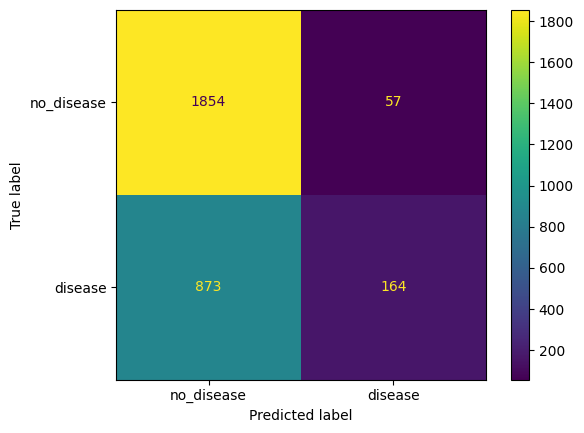

In [79]:
preds = model.predict(X_test)
nn_roc_auc = roc_auc_score(y_test,preds)
print(nn_roc_auc)

nn_cm = confusion_matrix(y_test,(preds > 0.5).astype(int)
)
nn_cm_disp = ConfusionMatrixDisplay(logist_cm,display_labels=['no_disease','disease'])
nn_cm_disp.plot()
plt.show()